In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import json

import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit

from data import *

plot_size = (12, 8)

In [3]:
def fix_date(df):
    df['time'] = df['time'].apply(lambda x:datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

def plot(plt, xlabel, ylabel="Count of Entries"):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [4]:
data = []

for i in range(0, 2):
    data.append(pd.read_csv(datasets_full[i] + ".csv"))
    data[i]['time'] = pd.to_datetime(data[i]['transfer_history.creation_date_string'], format='%d/%m/%Y\ %H:%M:%S')
    data[i]['hour'] = data[i]['time'].apply(lambda x: x.hour)
    data[i]['day'] = data[i]['time'].apply(lambda x: x.day)
    data[i]['speed'] = np.where(data[i]['transfer_history.time_transfer_sec'] > 0, data[i]['transfer_history.actually_transferred_size']/data[i]['transfer_history.time_transfer_sec'], data[i]['transfer_history.time_transfer_sec'])

In [5]:
print("Size of dataset : " + str(data[1].shape))
print("Unique Jobs : " + str(len(data[1]['transfer_history.task'].unique().tolist())))
print("Unique Qboxes : " + str(len(data[1]['transfer_history.qbox'].unique().tolist())))
print("Unique datasets sizes : " + str(len(data[1]['transfer_history.transfer_size'].unique().tolist())))

Size of dataset : (12206, 27)
Unique Jobs : 3724
Unique Qboxes : 25
Unique datasets sizes : 272


#### Check how many of the transfers failed

In [6]:
count_success = 0
count_failed = 0

print(np.unique(data[1]['transfer_history.state']))

for value in data[1]['transfer_history.state']:
    if(value == 'Completed'):
        count_success = count_success + 1
    else:
        count_failed = count_failed + 1

print("Completed transfers : " + str(count_success))
print("Failed transfers : " + str(count_failed))

['Completed' 'Failed']
Completed transfers : 12187
Failed transfers : 19


In [7]:
failed_qboxes = []
failed_time = []
failed_duration = []

for index, row in data[1].iterrows():
    if(row['transfer_history.state'] == "Failed"):
        failed_qboxes.append(row['transfer_history.qbox'])
        failed_time.append(row['time'])

temp = pd.DataFrame({'Failed Qboxes' : failed_qboxes, 'Failed Time' : failed_time})
print(temp)

                       Failed Qboxes         Failed Time
0   QBOX-4000-0000-1000-000000000001 2019-03-04 09:22:15
1   QBOX-4000-0000-1000-000000000002 2019-03-04 18:24:17
2   QBOX-4000-0000-1000-000000000006 2019-03-04 18:24:49
3   QBOX-4000-0000-1000-000000000005 2019-03-04 18:24:59
4   QBOX-4000-0000-1000-000000000001 2019-03-04 18:25:09
5   QBOX-4000-0000-1000-000000000002 2019-03-05 15:56:00
6   QBOX-4000-0000-1000-000000000002 2019-03-05 15:58:51
7   QBOX-4000-0000-1000-000000000002 2019-03-05 16:01:51
8   QBOX-4000-0000-1000-000000000002 2019-03-05 16:05:02
9   QBOX-4000-0000-1000-000000000004 2019-03-05 16:05:15
10  QBOX-4000-0000-1000-000000000002 2019-03-05 16:05:02
11  QBOX-4000-0000-1000-000000000002 2019-03-05 16:05:03
12  QBOX-4000-0000-1000-000000000002 2019-03-05 16:08:43
13  QBOX-4000-0000-1000-000000000006 2019-03-05 16:14:34
14  QBOX-4000-0000-1000-000000000001 2019-03-05 16:25:03
15                               NaN 2019-03-14 17:51:13
16                             

The failures are close in time. This says that failures are linked and are at each cluster of time when the failures occur, it was possibly one exact issue. Look at 1-4, 6-14.

#### Up vs Down

In [8]:
count_up = 0
count_down = 0

print(np.unique(data[1]['transfer_history.transfer_direction']))

for value in data[1]['transfer_history.transfer_direction']:
    if(value == "Down"):
        count_down = count_down + 1
    else:
        count_up = count_up + 1

print("Up transfers : " + str(count_up))
print("Down transfers : " + str(count_down))

['Down' 'Up']
Up transfers : 476
Down transfers : 11730


There are very low up transfers. Thre reason being that most of result the transfers happen via a VPN to the customer's proprietory servers. In such a case, it doesnt reflect in Qarnot systems.

### Validity of transfer and cache sizes

Check if `transfer_history.cached_data_size` + `transfer_history.actually_transferred_size` = `transfer_history.transfer_size`

[5387, 13, 6806]
Entries with difference beyond 100MB : 850


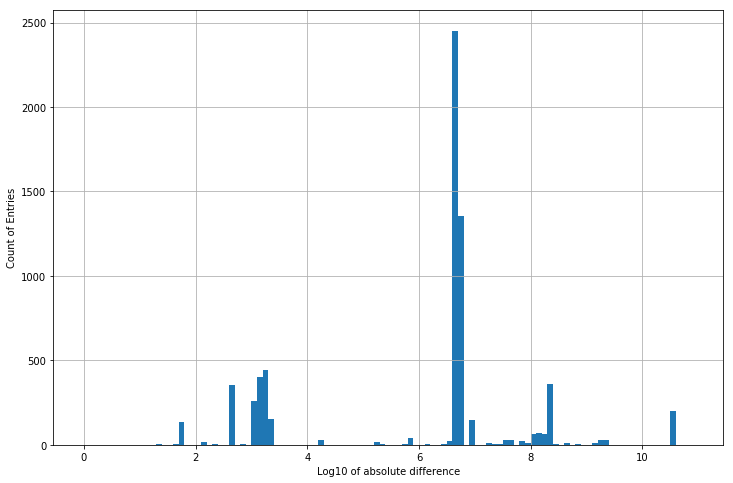

In [9]:
def check_transfer_data(temp, cut):
    count_true = 0
    count_less = 0
    count_more = 0
    more_than_cut = 0
    
    diff_per_list = []
    
    for index, row in temp.iterrows():
        a = row['transfer_history.cached_data_size']
        b = row['transfer_history.actually_transferred_size']
        c = row['transfer_history.transfer_size']
        
        if(a + b == c):
            count_true = count_true + 1
        else:   
            diff_per = abs(c - a - b)
            diff_per_list.append(diff_per)
            
            if(diff_per >= 10**cut):
                more_than_cut = more_than_cut + 1
            
            if(a + b < c):
                count_less = count_less + 1
            else:
                count_more = count_more + 1
    
    return [count_true, count_less, count_more], diff_per_list, more_than_cut

for i in range(1, 2):
    stat, diff, more_than_cut = check_transfer_data(data[i], 8)
    print(stat)
    print("Entries with difference beyond 100MB : " + str(more_than_cut))
    
    plt.figure(figsize=plot_size)
    plt.hist(np.log10(diff), bins=np.arange(0, 11, 0.1))
    plot(plt, "Log10 of absolute difference")

This doesnt match. The difference is mostly around 10 MB, and the transfer_size is always less than the sum. It is an issue with the way this is calculated. Qarnot is aware of this, but is not aware of the very large differences in size (eg. more than 100MB).

### Basic Transfer Size, Transfer Time analysis

The idea behind this analysis is to see if it is possible to extract some useful information regarding the size or the transfers. A good fit to the distrubution will help in speculation.

In [10]:
data_mts = []

for i in range(0, 2):
    data_mts.append(np.array(data[i]["transfer_history.transfer_size"]))
    # print("data[" + str(i) + "]")
    
    # print("Before removing negative and zeros : " + str(len(data_mts[i])))
    
    data_mts[i] = data_mts[i][data_mts[i] > 0.0]
    # print("After removing negative and zeros : " + str(len(data_mts[i])))

In [11]:
data_mtts = []

for i in range(0, 2):
    data_mtts.append(np.array(data[i]["transfer_history.time_transfer_sec"]))
    # print("data[" + str(i) + "]")
    
    # print("After removing negative and zeros : " + str(len(data_mtts[i])))
    
    data_mtts[i] = data_mtts[i][data_mtts[i] > 0.0]
    # print("After removing negative and zeros : " + str(len(data_mtts[i])))

In [12]:
def plot_hist(cut, temp, bins, name, plot_normal = True, plot_log=True):
    if(plot_normal):
    # Plot the base histogram
        plt.figure(figsize=plot_size)
        plt.hist(temp, bins=np.arange(bins[0][0], bins[0][1], bins[0][2]))

        # Add the cutline
        plt.axvline((10.0 ** cut), color='k', linestyle='dashed')

        # Plot
        plot(plt, name)

        # Print stats related to the dotted line
        print("Points above the dotted line : " + str(sum(temp > (10.0 ** cut))))
        print("Total points in the dataset : " + str(len(temp)))

    if(plot_log):
        # Get the log of the data
        temp = np.log10(temp)

        plt.figure(figsize=plot_size)

        # Now plot the logarithmic historgrams
        plt.hist(temp, bins=np.arange(bins[1][0], bins[1][1], bins[1][2]))

        # Calculate the bins for best fit
        bin_heights, bin_borders = np.histogram(temp, bins='auto')
        bin_widths = np.diff(bin_borders)
        bin_centers = bin_borders[:-1] + bin_widths / 2

        # popt has the [mean, amplitude, deviation]
        # popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[max(bin_heights), 0, 0])

        # x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

        # Add the guassian fit
        # lt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit', c='red')

        # Add the cutline
        plt.axvline(cut, color='k', linestyle='dashed')

        # Add the 99.9 percentile (3 sigma) deviation
        # plt.axvline(popt[0] + popt[2]*3, color='c', linestyle='dashed')
        # plt.axvline(popt[0] - popt[2]*3, color='c', linestyle='dashed')

        # Plot
        plot(plt, "Log of " + name)

### Transfer size

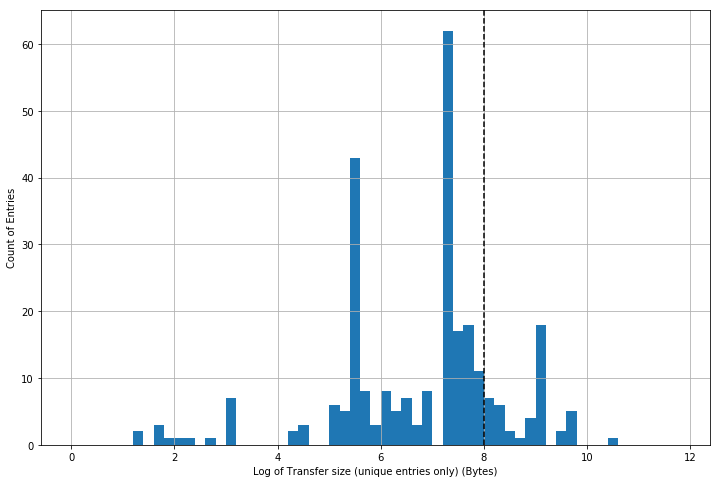

In [13]:
plot_hist(8, np.unique(data_mts[1]), [[0, 10**10, 10**8], [0, 12, 0.2]], "Transfer size (unique entries only) (Bytes)", plot_normal=False)

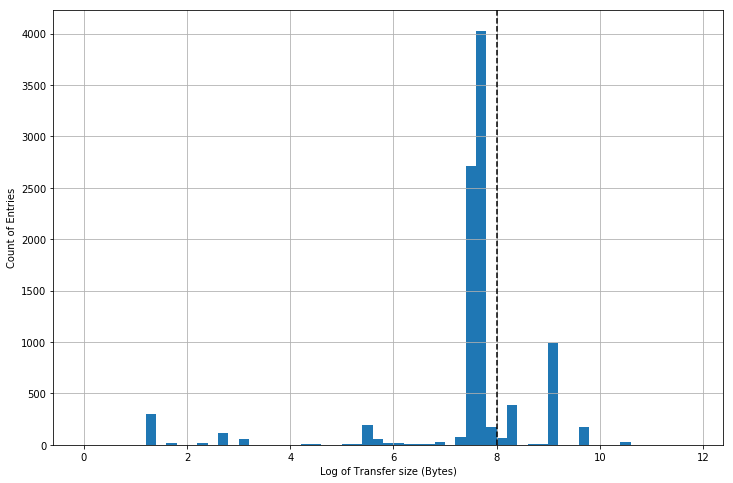

In [14]:
plot_hist(8, data_mts[1], [[0, 10**10, 10**8], [0, 12, 0.2]], "Transfer size (Bytes)", plot_normal=False)

### Transfer time

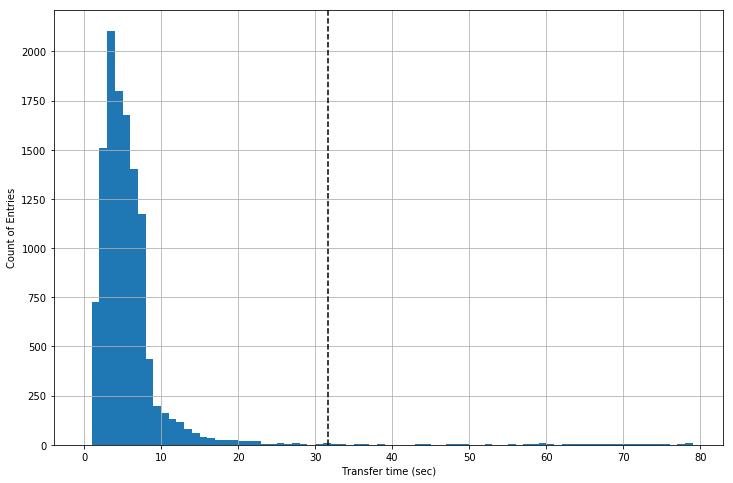

Points above the dotted line : 280
Total points in the dataset : 12099


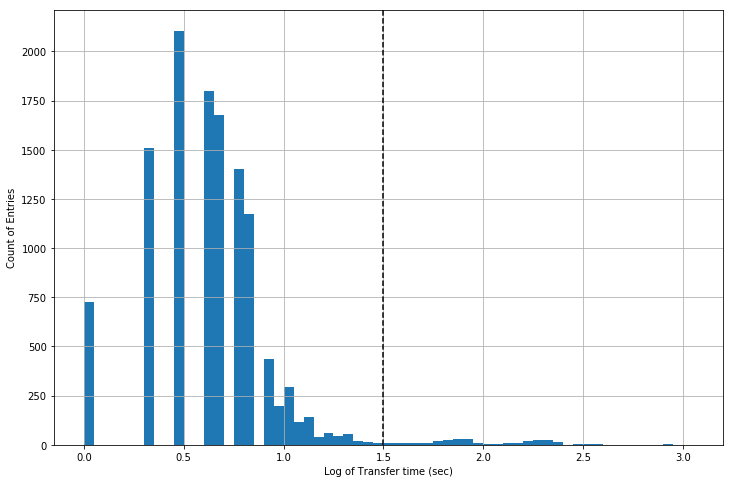

In [15]:
plot_hist(1.5, data_mtts[1], [[0, 8*(10**1), 1*(10**0)], [0, 3.1, 0.05]], "Transfer time (sec)")

The data given by this CSV file is only for 7, 30 days. We can use the Qarnot data extractor to extract datasets from all the time. This is given as a json output file and we study that here.

In [16]:
data_json_id = []
data_json_size = []

# Open the dataset file
with open(dataset_json[0] + ".json", 'r') as file:

    # Iterate over every line (which is a json object)
    for cnt, line in enumerate(file):

        # Parse this object
        parsed = json.loads(line)

        data_json_id.append(parsed["id"])
        data_json_size.append(parsed["size"])
        
data_json_id = np.array(data_json_id)
data_json_size = np.array(data_json_size)

In [17]:
print("Length of data : " + str(len(data_json_id)))
print("Unique ids in data : " + str(len(np.unique(data_json_id))))
print("Unique datasets in data : " + str(len(np.unique(data_json_size))))

Length of data : 33258
Unique ids in data : 33258
Unique datasets in data : 892


The json file has <job_id, task type, size>. Which always is unique. The code might be processing inside to remove the redundant ones. It is completely possible that jobs failed and so they were restarted with the same id, task type and obviously the same dataset.

Also the probability that the size is same is very small.

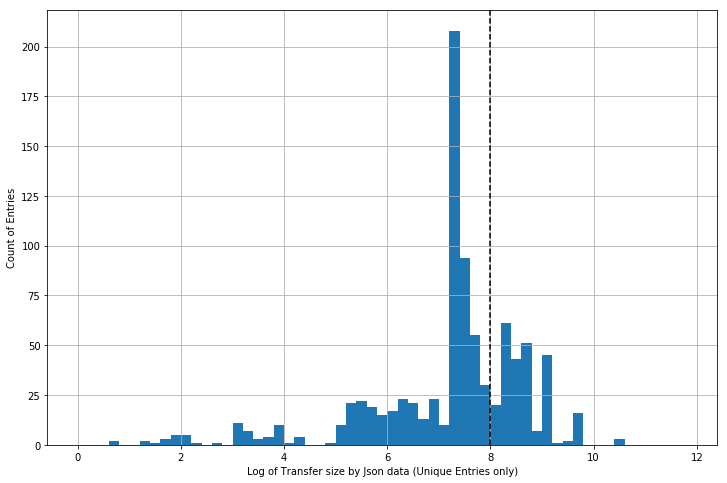

In [18]:
plot_hist(8, np.unique(data_json_size[data_json_size > 0]), [[0, 10**10, 10**8], [0, 12, 0.2]], "Transfer size by Json data (Unique Entries only)", plot_normal=False)

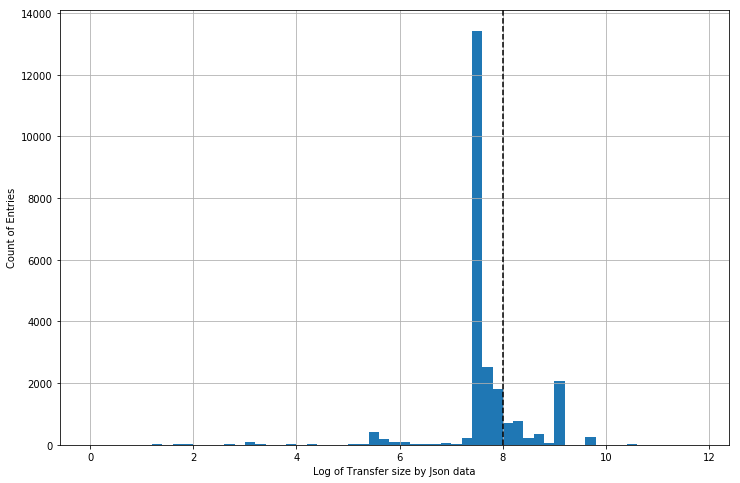

In [19]:
plot_hist(8, data_json_size[data_json_size > 0], [[0, 10**11, 10**9], [0, 12, 0.2]], "Transfer size by Json data", plot_normal=False)

The distribution of this looks the same as from the CSV file, but still this doesnt feel like it is fitting in some distribution. But it is good to have consitency.

### Transfer Speed analysis

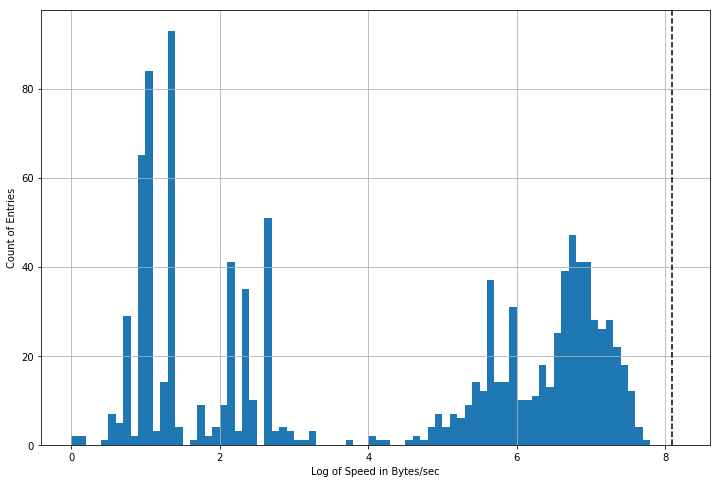

In [20]:
temp = data[1][['speed', 'transfer_history.time_transfer_sec', 'transfer_history.actually_transferred_size']]
temp = temp[temp['transfer_history.time_transfer_sec'] > 0]
temp = temp[temp['transfer_history.actually_transferred_size'] > 0]
temp = temp[temp['speed'] > 0]

plot_hist(np.log10(125000000), temp['speed'], [[0, 1*(10**8), 4*(10**6)], [0, 8.3, 0.1]], "Speed in Bytes/sec", plot_normal=False)

### Analysis of how the jobs map to data

In [21]:
print("Length of data : " + str(len(data[1]["transfer_history.task"])))
print("Unique jobs in data : " + str(len(data[1]["transfer_history.task"].unique().tolist())))

temp = set()
for index, row in data[1].iterrows():
    temp_ = row["transfer_history.task"]
    temp_ = str(temp_ ) + str(row["transfer_history.transfer_type"])
    temp.add(temp_)

print("Unique entries after adding task with type : " + str(len(temp)))

unique_data = len(data[1]["transfer_history.transfer_size"].unique().tolist())
print("Unique entries assuming that every dataset is of different size : " + str(unique_data))

Length of data : 12206
Unique jobs in data : 3724
Unique entries after adding task with type : 4845
Unique entries assuming that every dataset is of different size : 272


Surprising! There are very less unique datasets in the 30 month trace. 

On an average, a job is run 4 times, with possibly unique datases. Datasets are used on an average of 60 times with possibly different jobs.

% jobs which use more than one dataset : 31.61764705882353
% datasets which are used by more than one job : 33.16326530612245


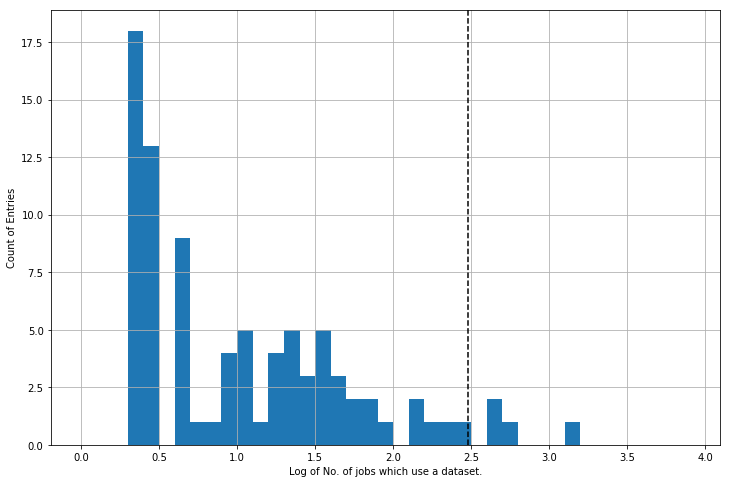

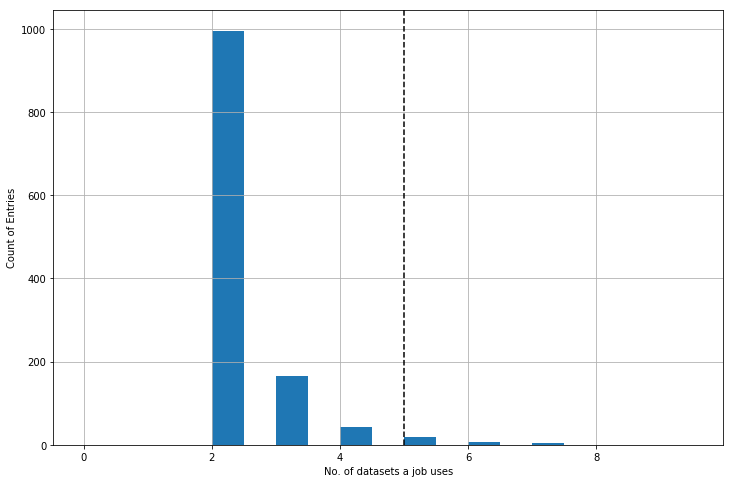

Points above the dotted line : 12
Total points in the dataset : 1235


In [22]:
temp = data[1].groupby(['transfer_history.transfer_size', 'transfer_history.task'])
temp = temp.size().unstack()

temp_bool = temp.notna()

temp_bool_data_to_job = np.array(temp_bool.sum(axis=1))
temp_bool_data_to_job = temp_bool_data_to_job[temp_bool_data_to_job != 1]
percent = 100*float(len(temp_bool_data_to_job))/len(data[1]['transfer_history.transfer_size'].unique().tolist())
print("% jobs which use more than one dataset : " + str(percent))

temp_bool_job_to_data = np.array(temp_bool.sum(axis=0))
temp_bool_job_to_data = temp_bool_job_to_data[temp_bool_job_to_data != 1]
percent = 100*float(len(temp_bool_job_to_data))/len(data[1]['transfer_history.task'].unique().tolist())
print("% datasets which are used by more than one job : " + str(percent))

plot_hist(np.log10(300), temp_bool_data_to_job, [[0, 2000, 50], [0, 4, 0.1]], "No. of jobs which use a dataset.", plot_normal=False)
plot_hist(np.log10(5), temp_bool_job_to_data, [[0, 10, 0.5], [0, 1, 0.1]], "No. of datasets a job uses", plot_log=False)

The distribution gives us more insight into how the job and the dataset dependency works.

### Cache analysis of datasets

Data is cached in the Qbox if `transfer_history.transfer_size` is equal to `transfer_history.cached_data_size`

In [23]:
data[1]["qbox_data_size"] = data[1]['transfer_history.qbox'].map(str)
data[1]["qbox_data_size"] = data[1]['qbox_data_size'].map(str) + "|" + data[1]['transfer_history.transfer_size'].map(str)

data[1]["is_cached"] = data[1]['transfer_history.transfer_size'] == data[1]['transfer_history.cached_data_size']

In [24]:
complete_entries = 0
partial_entries = 0
new_entries = 0

for index, row in data[1].iterrows():
    if(row['transfer_history.actually_transferred_size'] == 0):
        complete_entries = complete_entries + 1
    elif(row['transfer_history.cached_data_size'] == 0):
        new_entries = new_entries + 1
    else:
        partial_entries = partial_entries + 1

print("Cache completely present in {} entries".format(complete_entries))
print("Cache not present in {} entries".format(new_entries))
print("Cache partially present in {} entries".format(partial_entries))

Cache completely present in 11124 entries
Cache not present in 729 entries
Cache partially present in 353 entries


In [25]:
print("Data shape initially : " + str(data[1].shape))
temp = data[1][data[1]["transfer_history.state"] == "Completed"]
print("Data shape after dropping failed transfers : " + str(temp.shape))
temp = temp[["qbox_data_size", 'transfer_history.qbox', 'transfer_history.transfer_size', "is_cached"]]

temp = temp.dropna()
print("Data shape after dropping na : " + str(temp.shape))
print()
print("Unique Qboxes : " + str(len(temp['transfer_history.qbox'].unique().tolist())))
print("Unique datasets sizes : " + str(len(temp['transfer_history.transfer_size'].unique().tolist())))

Data shape initially : (12206, 29)
Data shape after dropping failed transfers : (12187, 29)
Data shape after dropping na : (9190, 4)

Unique Qboxes : 24
Unique datasets sizes : 241


The number of qboxes is very small. Also The number of datasets is very small. Let us see how many of these are related.

In [26]:
temp_ = temp.groupby(['qbox_data_size', 'is_cached'])
temp_ = temp_.size().unstack()
print(temp_.shape)

(720, 2)


Out of the 240x24, only 720 are valid mappings.

In [27]:
# Entries which are already cached or entries which are cached once"
data_qbox_mismatch = 0
normal_entries = 0
cache_not_present = 0

for index, row in temp_.iterrows():
    # size = int(re.search('|(.+?)', row.index)

    if(np.isnan(row[0]) and np.isnan(row[1])):
        data_qbox_mismatch = data_qbox_mismatch + 1
    elif(np.isnan(row[0]) or row[0] == 1):
        normal_entries = normal_entries + 1
    else:
        cache_not_present = cache_not_present + 1

print("Entries where cache was present or created : " + str(normal_entries))
print("Entries where cahce was not present : " +  str(cache_not_present))
print("Cache utilization percentage : " + str(100*normal_entries/(normal_entries + cache_not_present)))

Entries where cache was present or created : 590
Entries where cahce was not present : 130
Cache utilization percentage : 81.94444444444444


The reason this is very high is that a dataset is possibly used by 60 other jobs. Also, given that the number of Qboxes is very low, it is very possible that all the data is present everywhere. It is also possible that the jobs always run at the point closes to the customer and so the data always is present there.

This is not scalable though. As size of Qboxes increase, it is not affordable to put all the datasets nearly everywhere. Also when the condition that the process needs to run near the cusomter is removed, the job can be executed nearly anywhere and then the data will need to be equivalently omnipresent.

### Hourly Analysis

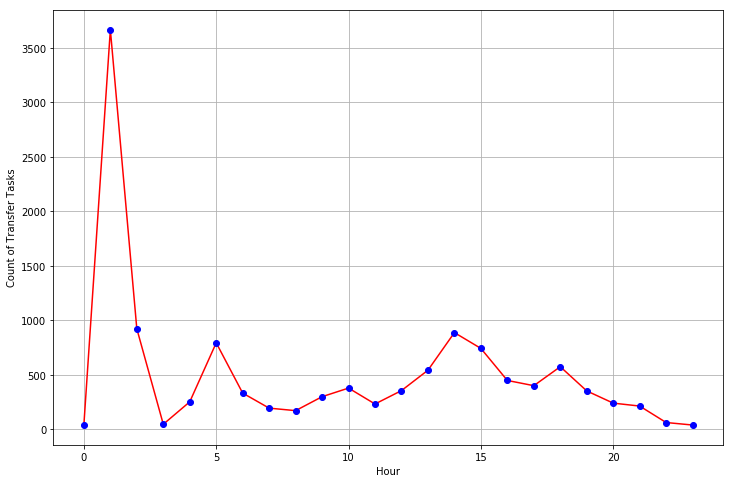

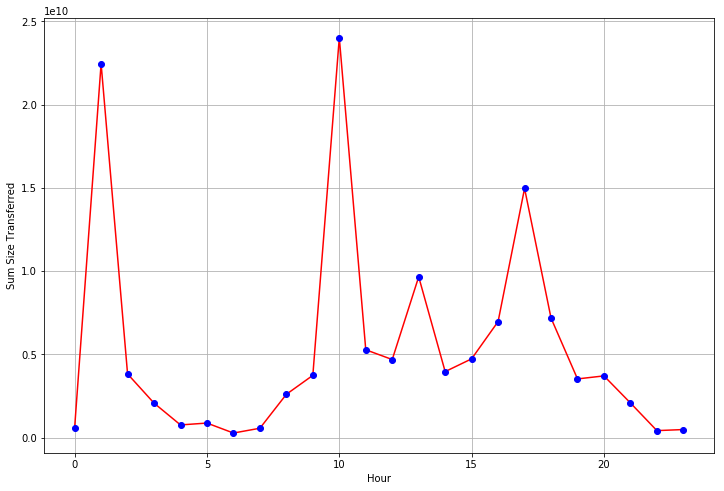

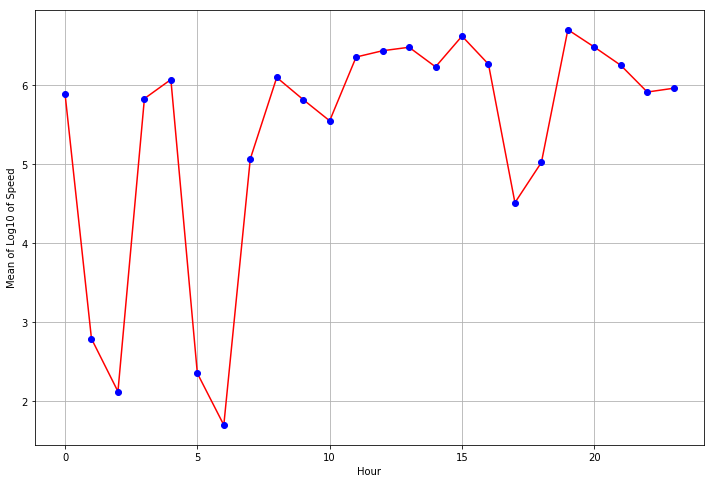

In [28]:
temp = data[1].groupby(['hour'])['transfer_history.actually_transferred_size'].count()

plt.figure(figsize=plot_size)
plt.plot(temp, 'r', temp, 'bo')
plot(plt, "Hour", "Count of Transfer Tasks")

temp = data[1].groupby(['hour'])['transfer_history.actually_transferred_size'].sum()

plt.figure(figsize=plot_size)
plt.plot(temp, 'r', temp, 'bo')
plot(plt, "Hour", "Sum Size Transferred")

temp = data[1][['transfer_history.actually_transferred_size', 'transfer_history.time_transfer_sec', 'hour', 'speed']]
    
temp = temp[temp['speed'] > 0]

temp['speed'] = temp['speed'].apply(lambda x:np.log10(x))
temp_ = temp.groupby('hour')['speed'].mean()

plt.figure(figsize=plot_size)
plt.plot(temp_, 'r', temp_, 'bo')
plot(plt, "Hour", "Mean of Log10 of Speed")

Slow speeds can be because of two factors
1. Files are very small - 2, 6
2. Network is congested due to large amount of transfers - 1, 6, 14
So, yes simultaneous downloads are resulting in congested networks

### Per Qbox Analysis

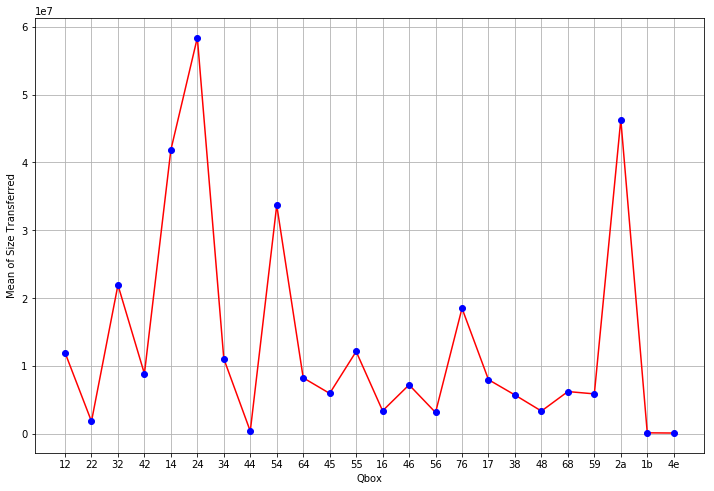

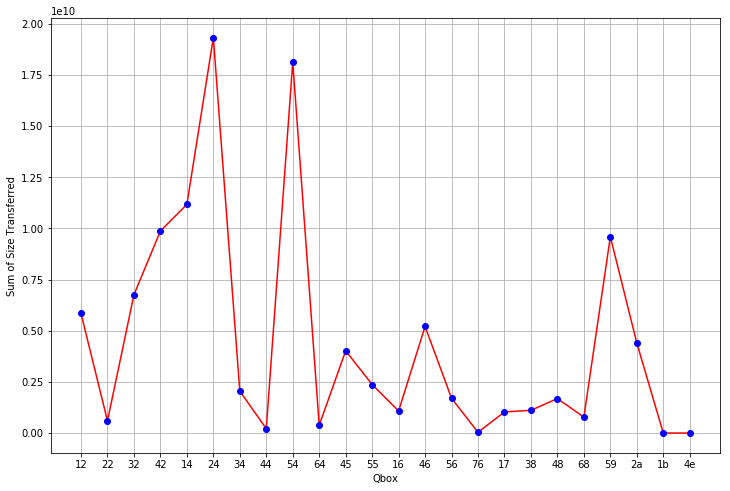

In [29]:
temp = data[1].groupby(['transfer_history.qbox'])['transfer_history.actually_transferred_size'].mean()
temp = temp.to_frame().reset_index()
temp['transfer_history.qbox_short'] = temp['transfer_history.qbox'].apply(lambda x: x[-1] + x[5])

plt.figure(figsize=plot_size)
plt.plot(temp['transfer_history.qbox_short'], temp['transfer_history.actually_transferred_size'], 'r', temp['transfer_history.qbox_short'], temp['transfer_history.actually_transferred_size'], 'bo')
plot(plt, "Qbox", "Mean of Size Transferred")

temp = data[1].groupby(['transfer_history.qbox'])['transfer_history.actually_transferred_size'].sum()
temp = temp.to_frame().reset_index()
temp['transfer_history.qbox_short'] = temp['transfer_history.qbox'].apply(lambda x: x[-1] + x[5])

plt.figure(figsize=plot_size)
plt.plot(temp['transfer_history.qbox_short'], temp['transfer_history.actually_transferred_size'], 'r', temp['transfer_history.qbox_short'], temp['transfer_history.actually_transferred_size'], 'bo')
plot(plt, "Qbox", "Sum of Size Transferred")

The mean size and the sum are nearly the same. Some qboxes are underused or possibly a lot of jobs are using the same datasets already present. Hence new datasets are not transferrred. This graph should be flattenned out possible?

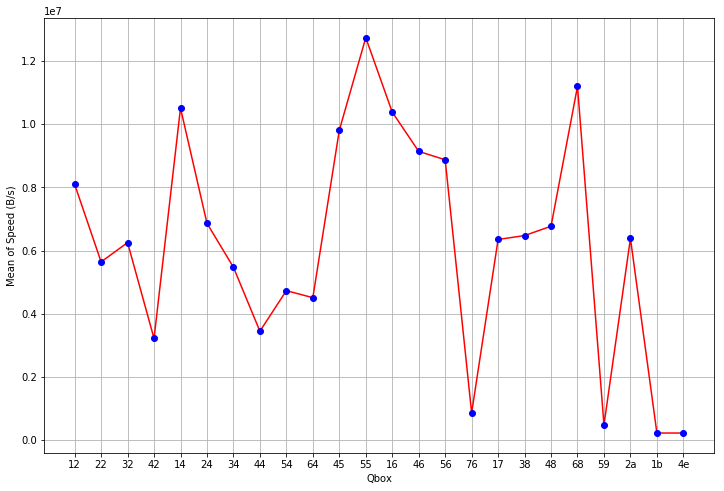

In [30]:
temp = data[1][['transfer_history.qbox', 'speed']]
temp = temp[temp['speed'] > 0]
temp = temp.groupby(['transfer_history.qbox'])['speed'].mean()
temp = temp.to_frame().reset_index()
temp['transfer_history.qbox_short'] = temp['transfer_history.qbox'].apply(lambda x: x[-1] + x[5])

plt.figure(figsize=plot_size)
plt.plot(temp['transfer_history.qbox_short'], temp['speed'], 'r', temp['transfer_history.qbox_short'], temp['speed'], 'bo')
plot(plt, "Qbox", "Mean of Speed (B/s)")

Even here, various qboxes have different usage speeds. It is unclear if if this slow speed is a result of small size of the files.

### Per hour Per Qbox analysis 

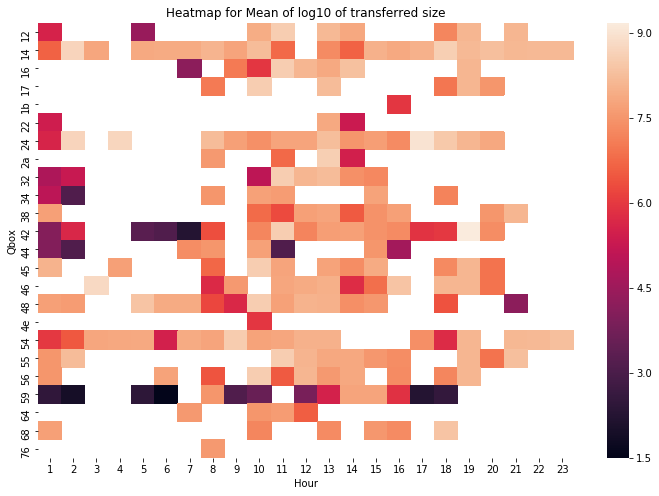

In [31]:
temp = data[1][['transfer_history.qbox', 'hour', 'transfer_history.actually_transferred_size']]
temp = temp[temp['transfer_history.qbox'].notna()]
temp = temp[temp['transfer_history.actually_transferred_size'] > 0]
temp['transfer_history.actually_transferred_size'] = temp['transfer_history.actually_transferred_size'].apply(lambda x: np.log10(x))
temp['transfer_history.qbox'] = temp['transfer_history.qbox'].apply(lambda x: x[-1] + x[5])
temp = temp.groupby(['transfer_history.qbox', 'hour'])['transfer_history.actually_transferred_size'].mean()
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox', columns='hour', values='transfer_history.actually_transferred_size')

plt.figure(figsize=plot_size)
sb.heatmap(temp)
plt.xlabel("Hour")
plt.ylabel("Qbox")
plt.title("Heatmap for Mean of log10 of transferred size")
plt.show()

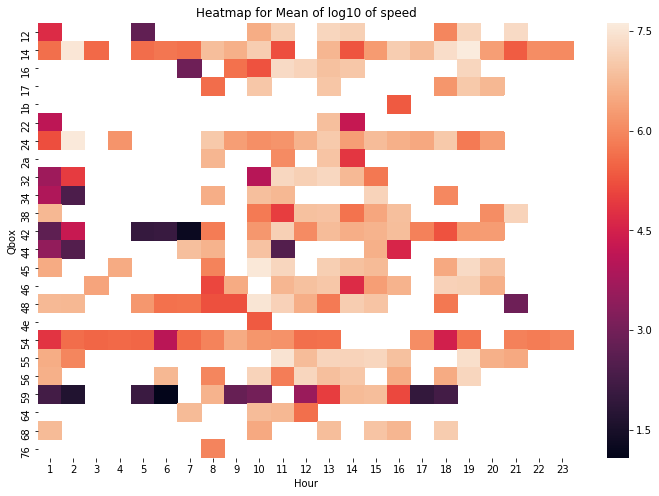

In [32]:
temp = data[1][['transfer_history.qbox', 'hour', 'speed']]
temp = temp[temp['transfer_history.qbox'].notna()]
temp = temp[temp['speed'] > 0]
temp['speed'] = temp['speed'].apply(lambda x: np.log10(x))
temp['transfer_history.qbox'] = temp['transfer_history.qbox'].apply(lambda x: x[-1] + x[5])
temp = temp.groupby(['transfer_history.qbox', 'hour'])['speed'].mean()
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox', columns='hour', values='speed')

plt.figure(figsize=plot_size)
sb.heatmap(temp)
plt.xlabel("Hour")
plt.ylabel("Qbox")
plt.title("Heatmap for Mean of log10 of speed")
plt.show()